# Predicting the Helpfulness of Amazon Reviews
### Keane Johnson and Tucker Anderson

This notebook builds a model that predicts the helpfulness of Amazon reviews. It uses the [2015 Amazon Review dataset](http://jmcauley.ucsd.edu/data/amazon/index.html), compiled by Julian McAuley, associate professor in the Computer Science department at the University of California, San Diego.

The dataset contains product reviews from Amazon from May 1996 - July 2014, and includes ratings, text, helpfulness votes, descriptions, category information, price, brand, and image features. It is broken into smaller subsets, organized by product category.

This notebook focuses on the Home and Kitchen sub-category, and uses the aforementioned features to predict helpfulness.

## Outline
- Import Libraries
- Load and Prepare Dataset
- Exploratory Data Analysis
- Baseline Model (Naive Bayes)
- Neural Net Models

## Import Libraries

In [2]:
# load packages
import gzip
import json
import os
import wget

import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load and Prepare Dataset

In [3]:
# load dataset - download directly from source, save to data directory

file_name = "data/reviews_Home_and_Kitchen_5.json.gz"
output_dir = "data"
url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Home_and_Kitchen_5.json.gz"

if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

if not os.path.isfile(file_name):
    file_name = wget.download(url, out=output_dir)

In [4]:
# helper functions to parse data from compressed json into pandas DF
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def get_dataframe(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')


# helper function to pull out total helpful votes
def get_helpful_votes(helpful):
    [helpful, total] = helpful
    return helpful


# helper function to pull out total votes (helpful and unhelpful)
def get_total_votes(helpful):
    [helpful, total] = helpful
    return total
    
    
# helper function to calculate helpfulness percentage 
def calculate_helpful_perc(helpful):
    [helpful, total] = helpful
    if total == 0:
        return 0
    else:
        return (helpful/total)

In [5]:
# create dataframe
df = get_dataframe(file_name)

# parse helpful column into new columns of helpful_votes, total_votes, helpful_perc
df['helpful_votes'] = df['helpful'].apply(get_helpful_votes)
df['total_votes'] = df['helpful'].apply(get_total_votes)
df['helpful_perc'] = df['helpful'].apply(calculate_helpful_perc)

## Exploratory Data Analysis

### Data Insights

In [6]:
df.shape

(551682, 12)

The dataset contains 551,682 rows and twelve columns.

In [7]:
df.sample(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpful_votes,total_votes,helpful_perc
476939,A1HAY4OS3C2PLZ,B007M2OGXG,Pierrot,"[0, 0]",Even better in person......Kong has elicited m...,5.0,Wise and witty design - big hit in my kitchen,1381881600,"10 16, 2013",0,0,0.0
477413,A28NQVJVUINPMP,B007MI2L1Y,Adrienne Morgan,"[0, 0]",I purchased this pillow in the Queen size inst...,3.0,Too full and too heavy,1361491200,"02 22, 2013",0,0,0.0
271438,A1T3D23WBJ9IQK,B001HWW03K,epabs,"[2, 2]","It really works, and work very well. I did a ...",5.0,Fantastic!!!,1371081600,"06 13, 2013",2,2,1.0
89726,A12ENBT314RFXR,B0002AZ9OU,Patricia Gray,"[1, 1]",I purchased this product because it was advert...,5.0,Great Bathroom Accessory,1242604800,"05 18, 2009",1,1,1.0
361640,A21ZR18W7U027R,B003IVU03K,David the Houseman,"[0, 0]",I shouldn't have expected a lot from $25 sheet...,2.0,Itchy & Scratchy,1381276800,"10 9, 2013",0,0,0.0


The twelve columns contain data including the reviewer name and review time, in addition to more applicable data to our models, like review text, summary, and helpful scores. The helpful column is a list of two numbers. The first number is the number of individuals who found that review helpful. The second number is the total number of individuals who scored that review.

We parse out these two numbers in helpful_votes and total_votes. We calculate the helpfulness percentage as well in helpful_perc. This is simply the number of helpful_votes divided by the number of total_votes. Helpful_perc will be our target variable in our models.

There are two sources of natural language in the dataset - reviewText and summary. We assume the reviewText will be more robust and impactful in determining whether a review is helpful or not. However, summary is a good resource for our models as well.

Next, we want to examine the completeness of our dataset.

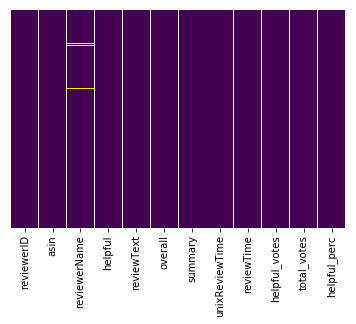

In [8]:
sns.heatmap(df.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')

This heatmap shows that there are missing values for some observations of reviewerName. However, with such a large dataset, we could be missing some values for other features that just do not appear on this chart

In [9]:
missing_df = pd.DataFrame(df.isnull().sum())
missing_df

,0
reviewerID,0
asin,0
reviewerName,4953
helpful,0
reviewText,0
overall,0
summary,0
unixReviewTime,0
reviewTime,0
helpful_votes,0


We confirm that we are only missing values for reviewerName. We reason that this does not have an impact on our analysis because we will be using primarily the reviewText, and possibly the summary, to determine a review's helpfulness. Additionally, we argue that individuals do not consistently use a reviewer's name when determining a review's helpfulness.

### Summary Statistics

After reviewing some sample data, and examining missing values, we next look at some summary statistics of our dataset.

In [10]:
df.describe()

,overall,unixReviewTime,helpful_votes,total_votes,helpful_perc
count,551682.000000,5.516820e+05,551682.000000,551682.000000,551682.000000
mean,4.316655,1.348687e+09,3.497348,3.939469,0.367910
std,1.110749,6.120238e+07,76.539142,77.801556,0.456931
min,1.000000,9.572256e+08,0.000000,0.000000,0.000000
25%,4.000000,1.331770e+09,0.000000,0.000000,0.000000
50%,5.000000,1.367626e+09,0.000000,0.000000,0.000000
75%,5.000000,1.388880e+09,1.000000,2.000000,1.000000
max,5.000000,1.406074e+09,52176.000000,52861.000000,1.000000


These summary statistics show that over half of our observations have a 0% helpfulness. In addition, these observations have zero total votes. This means that the reviews simply haven't been voted upon. We should remove these observations from our dataset because our model could misinterpret the 0% helpful_perc to mean that the review was not helpful when in fact the review just hasn't been voted upon.

### Examining the Target Variable

We can use a histogram to visualize the distribution of helpful percentages.

Text(0.5,1,'Histogram of Helpful Percentages')

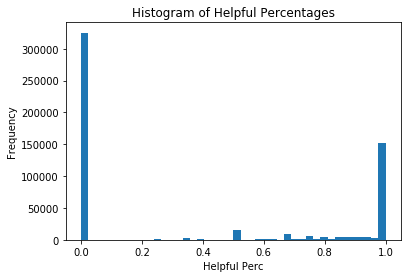

In [11]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)
n, bins, patches = ax1.hist(x=df['helpful_perc'], bins='auto')
                                 
ax1.set_xlabel('Helpful Perc')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Helpful Percentages')

This histogram shows that the majority of reviews have a 0% helpful percentage, with the second most prevalent percentage being 100%. However, our dataset needs to be cleaned to remove observations where there are no total votes.

### Data Cleaning

We want to drop rows where there are no total votes whatsoever, to prevent our model from interpreting these reviews as being unhelpful.

In [20]:
df = df[df.total_votes != 0]
df.shape

The size of our dataset is now 248,634 rows. Still robust enough to use for our models. Next we can examine the new distribution of helpful_perc.

In [21]:
df.describe()

,overall,unixReviewTime,helpful_votes,total_votes,helpful_perc
count,248634.000000,2.486340e+05,248634.000000,248634.000000,248634.000000
mean,4.108529,1.323709e+09,7.760097,8.741097,0.816338
std,1.273446,7.365012e+07,113.866220,115.710631,0.311763
min,1.000000,9.572256e+08,0.000000,1.000000,0.000000
25%,4.000000,1.293667e+09,1.000000,1.000000,0.750000
50%,5.000000,1.349827e+09,2.000000,2.000000,1.000000
75%,5.000000,1.376611e+09,4.000000,5.000000,1.000000
max,5.000000,1.405987e+09,52176.000000,52861.000000,1.000000


The median helpful_perc is 100%. We could be at risk of not having a good distribution of data to train on. This could result in our model being overly optimistic and inflating the helpfulness scores of reviews. We can visualize this skew with another histogram.

Text(0.5,1,'Histogram of Helpful Percentages')

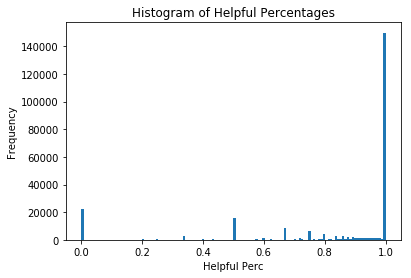

In [19]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(1, 1, 1)
n, bins, patches = ax2.hist(x=df['helpful_perc'], bins='auto')
                                 
ax2.set_xlabel('Helpful Perc')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of Helpful Percentages')

## Baseline Model (Naive Bayes)

In [22]:
# dataset
df.sample(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpful_votes,total_votes,helpful_perc
255045,A2L42QEWR77PKZ,B001C2J0FG,Tex,"[102, 122]",We bought this microwave oven because it also ...,1.0,Convection oven is useless,1235347200,"02 23, 2009",102,122,0.836066
509271,A928HCGAQTU6X,B00A2KD8HA,sarabella,"[0, 1]",I do love oxo products and am a sucker for kit...,4.0,Love! ...for wet ingredients...,1362528000,"03 6, 2013",0,1,0.000000
316369,AHN86VFJIJ2JP,B002KCMH6G,Chicago Book Addict,"[11, 14]",In receiving this product I was skeptical of h...,4.0,"Bulky design, but cleans well",1260230400,"12 8, 2009",11,14,0.785714
453786,A3B1V3AUUV13R6,B005TOVZSS,Adrien Caldwell,"[6, 8]",This is a wonderful comforter to have for my k...,5.0,Very good quality and does the job nicely.,1383782400,"11 7, 2013",6,8,0.750000
99468,A1RIZ330QGQTU5,B00063QPYQ,David Burrell,"[1, 2]","A good product that needs, in my home, to be a...",4.0,Works well to protect.,1360368000,"02 9, 2013",1,2,0.500000
